# A first exploration and model
Derived from: https://www.kaggle.com/sunnynevarekar/home-credit-default-xgboost

Choose the import function that you want to try out

In [1]:
# RAPIDS version
import cudf
import cudf as dd
from cuml.model_selection import train_test_split
import numpy as np
import xgboost as xgb
from cuml.metrics import confusion_matrix
tree_type = 'gpu_hist'

In [2]:
# pandas version
import cudf
import pandas as dd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import confusion_matrix 
import numpy as np
tree_type = 'hist'

In [3]:
import time
start = time.time()

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

For a first exploration, we will just use the train and test datasets without the extra tables

In [5]:
%%time
# Load in the data

train = dd.read_parquet('raw_data/train.parquet')
test = dd.read_parquet('raw_data/test.parquet')

CPU times: user 589 ms, sys: 259 ms, total: 849 ms
Wall time: 449 ms


We can see that some columns have nulls

In [6]:
(train.isnull().any()[train.isnull().any()] == True).index

Index(['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'OWN_CAR_AGE',
       'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG',
       'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG',
       'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG',
       'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG',
       'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE',
       'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE',
       'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE',
       'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE',
       'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE',
       'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI',
       'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI',
       'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMI

Lets see that which columns have loads and loads of nulls

In [7]:
def see_percent_missing_values(df):
    
    total_missing = df.isnull().sum()/df.shape[0]
    percent_missing = total_missing*100
    return percent_missing.sort_values(ascending=False).round(1)

In [8]:
app_train_mis_values = see_percent_missing_values(train)

In [9]:
df_app_train_miss_values= dd.DataFrame({'columns': app_train_mis_values.index, 
                                        'missing percent': app_train_mis_values.values})

In [10]:
df_app_train_miss_values

,columns,missing percent
0,COMMONAREA_MEDI,69.9
1,COMMONAREA_AVG,69.9
2,COMMONAREA_MODE,69.9
3,NONLIVINGAPARTMENTS_MODE,69.4
4,NONLIVINGAPARTMENTS_MEDI,69.4
...,...,...
116,REG_CITY_NOT_LIVE_CITY,0.0
117,LIVE_REGION_NOT_WORK_REGION,0.0
118,REG_REGION_NOT_WORK_REGION,0.0
119,HOUR_APPR_PROCESS_START,0.0


In [11]:
type(df_app_train_miss_values)

pandas.core.frame.DataFrame

lets drop those columns which have a high percentage of missing values

In [12]:
# NOTE that in cudf some conversions are slightly different so whilst it is mostly 
# a drop in replacement sometimes adjustments do have to be made
if type(df_app_train_miss_values) == cudf.core.dataframe.DataFrame:
    drop_columns = df_app_train_miss_values[df_app_train_miss_values['missing percent'] \
                                        >= 40]['columns'].to_arrow().to_pylist()
else:
    drop_columns = df_app_train_miss_values[df_app_train_miss_values['missing percent'] \
                                        >= 40]['columns'].tolist()

train = train.drop(drop_columns, axis=1)
test = test.drop(drop_columns, axis=1)

In [13]:
print(train.shape)
print(test.shape)

(307511, 72)
(48744, 71)


At the moment our data has a range of numerical and categorical data. In order for most algorithms to handle categorical data, we need to convert it into a numerical representation.
See: https://www.datacamp.com/community/tutorials/categorical-data for more info

In [14]:
train_target = train['TARGET']
train = train.drop('TARGET', axis=1)

In [15]:
# here we will use a basic dummy treatment
# we merged the dataframes first because when we dummify 
# we could have some columns only in train or only in test. Merging first will prevent this 
unified = dd.concat([train, test])

In [16]:
dummy_cols = unified.select_dtypes(['bool', 'O', 'category']).columns.tolist()

In [17]:
unified = dd.get_dummies(unified, columns=dummy_cols, dtype='int64')

In [18]:
unified.select_dtypes('Int64')

,CNT_CHILDREN,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,CNT_FAM_MEMBERS,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,...,FLAG_DOCUMENT_17_False,FLAG_DOCUMENT_17_True,FLAG_DOCUMENT_18_False,FLAG_DOCUMENT_18_True,FLAG_DOCUMENT_19_False,FLAG_DOCUMENT_19_True,FLAG_DOCUMENT_20_False,FLAG_DOCUMENT_20_True,FLAG_DOCUMENT_21_False,FLAG_DOCUMENT_21_True
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,0,-9461,-637,-2120,1,2,2,2,2,-1134,...,1,0,1,0,1,0,1,0,1,0
100003,0,-16765,-1188,-291,2,1,0,1,0,-828,...,1,0,1,0,1,0,1,0,1,0
100004,0,-19046,-225,-2531,1,0,0,0,0,-815,...,1,0,1,0,1,0,1,0,1,0
100006,0,-19005,-3039,-2437,2,2,0,2,0,-617,...,1,0,1,0,1,0,1,0,1,0
100007,0,-19932,-3038,-3458,1,0,0,0,0,-1106,...,1,0,1,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456221,0,-19970,-5169,-3399,1,1,0,1,0,-684,...,1,0,1,0,1,0,1,0,1,0
456222,2,-11186,-1149,-3003,4,2,0,2,0,0,...,1,0,1,0,1,0,1,0,1,0
456223,1,-15922,-3037,-1504,3,0,0,0,0,-838,...,1,0,1,0,1,0,1,0,1,0


In [19]:
# XGB for pandas does not like Int64
for col in unified.select_dtypes('Int64').columns.tolist():
    unified[col] = unified[col].fillna(int(unified[col].mean()))
    unified[col] = unified[col].astype('int64')

In [20]:
## Splitting back into train and test
train = unified[0:307511]
test = unified[307511:]

In [21]:
print(train.shape)
print(test.shape)

(307511, 243)
(48744, 243)


In [22]:
train.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,FLAG_DOCUMENT_17_False,FLAG_DOCUMENT_17_True,FLAG_DOCUMENT_18_False,FLAG_DOCUMENT_18_True,FLAG_DOCUMENT_19_False,FLAG_DOCUMENT_19_True,FLAG_DOCUMENT_20_False,FLAG_DOCUMENT_20_True,FLAG_DOCUMENT_21_False,FLAG_DOCUMENT_21_True
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,-3648.0,-2120,...,1,0,1,0,1,0,1,0,1,0
100003,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,-1186.0,-291,...,1,0,1,0,1,0,1,0,1,0
100004,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,-4260.0,-2531,...,1,0,1,0,1,0,1,0,1,0
100006,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,-9833.0,-2437,...,1,0,1,0,1,0,1,0,1,0
100007,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,-4311.0,-3458,...,1,0,1,0,1,0,1,0,1,0


## Build Model

In [23]:
# TODO - confirm -  we have an unbalanced pos to negative ratio so it will help to feed this into xgb
ratio = (train_target == 0).sum()/ (train_target == 1).sum()
ratio

11.387150050352467

In [24]:
X_train, X_test, y_train, y_test = train_test_split(train, train_target, 
                                                    test_size=0.2, random_state=1)

In [25]:
X_train.dtypes.unique()

array([dtype('int64'), dtype('float64')], dtype=object)

In [27]:
clf = xgb.XGBClassifier(n_estimators=1000, objective='binary:logistic', 
                        tree_method=tree_type, gamma=0.1, subsample=0.5, 
                        scale_pos_weight=ratio, use_label_encoder=False)

In [28]:
clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], 
        eval_metric='auc', early_stopping_rounds=10)

[0]	validation_0-auc:0.71473
[1]	validation_0-auc:0.72696
[2]	validation_0-auc:0.72965
[3]	validation_0-auc:0.73232
[4]	validation_0-auc:0.73594
[5]	validation_0-auc:0.73775
[6]	validation_0-auc:0.73869
[7]	validation_0-auc:0.73925
[8]	validation_0-auc:0.74115
[9]	validation_0-auc:0.74203
[10]	validation_0-auc:0.74276
[11]	validation_0-auc:0.74343
[12]	validation_0-auc:0.74319
[13]	validation_0-auc:0.74368
[14]	validation_0-auc:0.74347
[15]	validation_0-auc:0.74386
[16]	validation_0-auc:0.74465
[17]	validation_0-auc:0.74502
[18]	validation_0-auc:0.74499
[19]	validation_0-auc:0.74494
[20]	validation_0-auc:0.74569
[21]	validation_0-auc:0.74631
[22]	validation_0-auc:0.74612
[23]	validation_0-auc:0.74602
[24]	validation_0-auc:0.74672
[25]	validation_0-auc:0.74665
[26]	validation_0-auc:0.74664
[27]	validation_0-auc:0.74718
[28]	validation_0-auc:0.74719
[29]	validation_0-auc:0.74686
[30]	validation_0-auc:0.74653
[31]	validation_0-auc:0.74626
[32]	validation_0-auc:0.74609
[33]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=32, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=11.387150050352467,
              subsample=0.5, tree_method='hist', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

## Evaluate Model

In [30]:
y_predict = clf.predict(X_test)

In [31]:
confusion_matrix(y_test, y_predict)

array([[39625, 16908],
       [ 1713,  3257]])

## See Feature Importances

In [32]:
## get shap - note that shap is only in the booster object not in the sklearn API XGBClassifier
booster = clf.get_booster()

In [33]:
y_preds_2 = booster.predict(xgb.DMatrix(X_test), pred_contribs=True) 

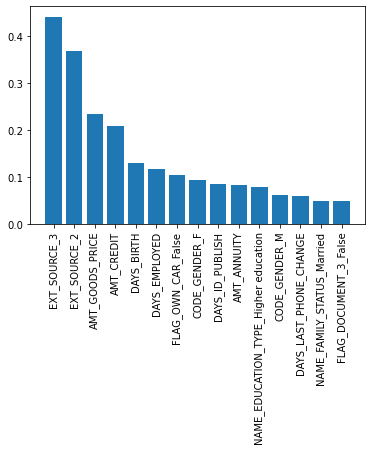

In [34]:
def plot_feature_importance(feature_names, shap_values, top=15):
     # Get the mean absolute contribution for each feature
     aggregate = np.mean(np.abs(shap_values[:, 0:-1]), axis=0)
     # sort by magnitude
     z = [(x, y) for y, x in sorted(zip(aggregate, feature_names), reverse=True)]
     z = list(zip(*z))
     plt.bar(z[0][0:top], z[1][0:top])
     plt.xticks(rotation=90)
     plt.show()

plot_feature_importance(train.columns.tolist(), y_preds_2)

In [32]:
end = time.time()
print(end - start)

8.385368824005127


From my testing:

RAPIDS: 6.516420841217041

CPU: 8.385368824005127

